# Installations

In [1]:
!pip install gymnasium-connect-four==1.3.1 stable-baselines3==2.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import namedtuple, deque
import gymnasium as gym
import math
import time
import matplotlib.pyplot as plt
import os

# Environment specific
from connect_four_gymnasium import ConnectFourEnv
from connect_four_gymnasium.players import BabySmarterPlayer, ChildSmarterPlayer, TeenagerSmarterPlayer, AdultSmarterPlayer
from connect_four_gymnasium.tools import EloLeaderboard
from connect_four_gymnasium.players import (ModelPlayer)

# Seeds

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# For deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check device

In [4]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Neural network architecture (can add multiple layers, skip connections, etc.)

In [6]:
class DQN(nn.Module):
    def __init__(self, outputs):
        super(DQN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm2d(32)
        # self.conv4 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.bn4 = nn.BatchNorm2d(32)
        # self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.bn5 = nn.BatchNorm2d(32)
        # self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.bn6 = nn.BatchNorm2d(32)
        # self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.bn7 = nn.BatchNorm2d(32)
        # self.conv8 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.bn8 = nn.BatchNorm2d(32)
        # self.conv9 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.bn9 = nn.BatchNorm2d(32)

        # Fully connected layers
        linear_input_size = 6 * 7 * 32  # Connect Four board size
        self.MLP1 = nn.Linear(linear_input_size, 50)
        self.MLP2 = nn.Linear(50, 50)
        self.MLP3 = nn.Linear(50, 50)
        self.MLP4 = nn.Linear(50, outputs)

        self.dropout = nn.Dropout(p=0)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.leaky_relu(self.bn3(self.conv3(x)))
        # x = F.leaky_relu(self.bn4(self.conv4(x)))
        # x = F.leaky_relu(self.bn5(self.conv5(x)))
        # x = F.leaky_relu(self.bn6(self.conv6(x)))
        # x = F.leaky_relu(self.bn7(self.conv7(x)))
        # x = F.leaky_relu(self.bn8(self.conv8(x)))
        # x = F.leaky_relu(self.bn9(self.conv9(x)))

        x = x.view(x.size(0), -1)  # flatten

        x = self.dropout(F.leaky_relu(self.MLP1(x)))
        x = self.dropout(F.leaky_relu(self.MLP2(x)))
        x = self.dropout(F.leaky_relu(self.MLP3(x)))
        return self.MLP4(x)

In [7]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Experience(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [8]:
class DQNAgent:
    def __init__(self, env, device=device):
        self.env = env
        # Auto-detect device (use GPU if available)
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        self.action_size = env.action_space.n

        # Create policy and target networks
        self.policy_net = DQN(self.action_size).to(device)
        self.target_net = DQN(self.action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Hyperparameters
        self.learning_rate = 0.0001
        self.gamma = 0.99  # discount factor
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    def preprocess_state(self, state):
        """Convert state to tensor with proper dimensions for CNN input"""
        # Convert to float, add channel dimension, and move to device
        # Adding unsqueeze(0) for batch dimension and unsqueeze(0) again for channel dimension
        tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(self.device)
        return tensor

    def select_action(self, state, valid_actions):
        """Select an action using epsilon-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return random.choice(valid_actions)
        else:
            with torch.no_grad():
                state_tensor = self.preprocess_state(state)
                q_values = self.policy_net(state_tensor)

                # Mask invalid actions with very low values
                masked_q_values = torch.full_like(q_values, float('-inf'))
                for action in valid_actions:
                    masked_q_values[0][action] = q_values[0][action]

                return masked_q_values.argmax().item()

    def optimize_model(self):
        """Perform one step of optimization"""
        if len(self.memory) < self.batch_size:
            return

        experiences = self.memory.sample(self.batch_size)
        batch = Experience(*zip(*experiences))

        # Process states with proper dimensions for CNN (batch, channels, height, width)
        # Each state needs to be unsqueezed to add the channel dimension
        states = [np.expand_dims(s, axis=0) for s in batch.state]  # Add channel dimension
        next_states = [np.expand_dims(s, axis=0) for s in batch.next_state]  # Add channel dimension

        # Convert to tensors and move to device
        state_batch = torch.FloatTensor(np.array(states)).to(self.device)
        action_batch = torch.tensor(batch.action, dtype=torch.int64, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32, device=self.device)
        next_state_batch = torch.FloatTensor(np.array(next_states)).to(self.device)
        done_batch = torch.tensor(batch.done, dtype=torch.bool, device=self.device)

        # Compute Q(s_t, a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states
        next_state_values = torch.zeros(self.batch_size, device=self.device)
        with torch.no_grad():
            next_state_values[~done_batch] = self.target_net(next_state_batch[~done_batch]).max(1)[0]

        # Compute the expected Q values
        expected_state_action_values = reward_batch + (self.gamma * next_state_values)

        # Compute loss
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        """Update target network with policy network weights"""
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def train(self, num_episodes, update_target_every=10):
        """Train the agent"""
        scores = []
        avg_scores = []
        episode_wins = []
        total_steps = 0

        from tqdm.notebook import tqdm
        try:
            # Use tqdm for progress bar in notebooks
            progress_bar = tqdm(range(num_episodes), desc="Training")
        except:
            progress_bar = range(num_episodes)

        for episode in progress_bar:

            state, _ = self.env.reset()
            done = False
            score = 0
            steps = 0

            while not done:
                # Get valid actions
                valid_actions = self.env.get_valid_actions()

                # Select and perform action
                action = self.select_action(state, valid_actions)
                next_state, reward, done, truncated, _ = self.env.step(action)

                episode_won = False
                if reward == 1:
                  episode_won = True

                # Store transition in memory
                self.memory.push(state, action, next_state, reward, done)

                # Move to the next state
                state = next_state
                score += reward
                steps += 1
                total_steps += 1

                # Perform optimization step
                self.optimize_model()

                # Update target network periodically based on steps
                if total_steps % (update_target_every * 100) == 0:
                    self.update_target_network()
                    print(f"Target network updated at step {total_steps}")

            scores.append(score)
            episode_wins.append(1 if episode_won else 0)

            # Calculate running average
            avg_score = np.mean(scores[-100:]) if len(scores) >= 100 else np.mean(scores)
            avg_scores.append(avg_score)

            # Win rate over last 100 episodes
            win_rate_100 = np.mean(episode_wins[-100:]) if len(episode_wins) >= 100 else np.mean(episode_wins)

            # Update progress bar description
            if isinstance(progress_bar, tqdm):
                progress_bar.set_description(f"Ep: {episode} | Score: {score:.2f} | Avg: {avg_score:.2f} | ε: {self.epsilon:.3f}")

            if episode % 10 == 0:
                print(f"Episode: {episode}, Score: {score:.2f}, Avg Score: {avg_score:.2f}, Win Rate (last 100): {win_rate_100:.2f}, Epsilon: {self.epsilon:.3f}, Steps: {steps}")

        return scores, avg_scores

    def play(self, board):
        """Method to interface with ConnectFourEnv opponent mechanism"""
        valid_actions = []
        for col in range(7):  # Connect Four has 7 columns
            if board[0, col] == 0:  # Check if column isn't full
                valid_actions.append(col)

        if not valid_actions:
            return 0  # Fallback if no valid actions (shouldn't happen in Connect Four)

        with torch.no_grad():
            # Add channel dimension for CNN input
            state_tensor = torch.FloatTensor(board).unsqueeze(0).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor)[0]

            # Mask invalid actions
            masked_q_values = torch.full_like(q_values, float('-inf'))
            for action in valid_actions:
                masked_q_values[action] = q_values[action]

            return masked_q_values.argmax().item()

    def getName(self):
        """Return agent name for display in the environment"""
        return "DQN Agent"

    def save(self, path):
        """Save model weights"""
        torch.save({
            'policy_net_state_dict': self.policy_net.state_dict(),
            'target_net_state_dict': self.target_net.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon
        }, path)

    def load(self, path):
        """Load model weights"""
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
        self.target_net.load_state_dict(checkpoint['target_net_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']

# Train

In [9]:
env = ConnectFourEnv(opponent=BabySmarterPlayer())
agent = DQNAgent(env)

# Training parameters
num_episodes = 500

# Train the agent
scores, avg_scores = agent.train(num_episodes=num_episodes)

Using device: cpu


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Episode: 0, Score: -1.00, Avg Score: -1.00, Win Rate (last 100): 0.00, Epsilon: 1.000, Steps: 9
Episode: 10, Score: -1.00, Avg Score: -0.27, Win Rate (last 100): 0.36, Epsilon: 0.794, Steps: 11
Episode: 20, Score: 1.00, Avg Score: 0.14, Win Rate (last 100): 0.57, Epsilon: 0.446, Steps: 10
Episode: 30, Score: 1.00, Avg Score: 0.10, Win Rate (last 100): 0.55, Epsilon: 0.287, Steps: 6
Episode: 40, Score: 1.00, Avg Score: 0.17, Win Rate (last 100): 0.59, Epsilon: 0.187, Steps: 8
Episode: 50, Score: 1.00, Avg Score: 0.25, Win Rate (last 100): 0.63, Epsilon: 0.127, Steps: 5
Episode: 60, Score: -1.00, Avg Score: 0.31, Win Rate (last 100): 0.66, Epsilon: 0.080, Steps: 10
Episode: 70, Score: 1.00, Avg Score: 0.35, Win Rate (last 100): 0.68, Epsilon: 0.055, Steps: 7
Episode: 80, Score: 1.00, Avg Score: 0.38, Win Rate (last 100): 0.69, Epsilon: 0.041, Steps: 5
Episode: 90, Score: -1.00, Avg Score: 0.36, Win Rate (last 100): 0.68, Epsilon: 0.028, Steps: 6
Episode: 100, Score: 1.00, Avg Score: 0.38

# Make Plots

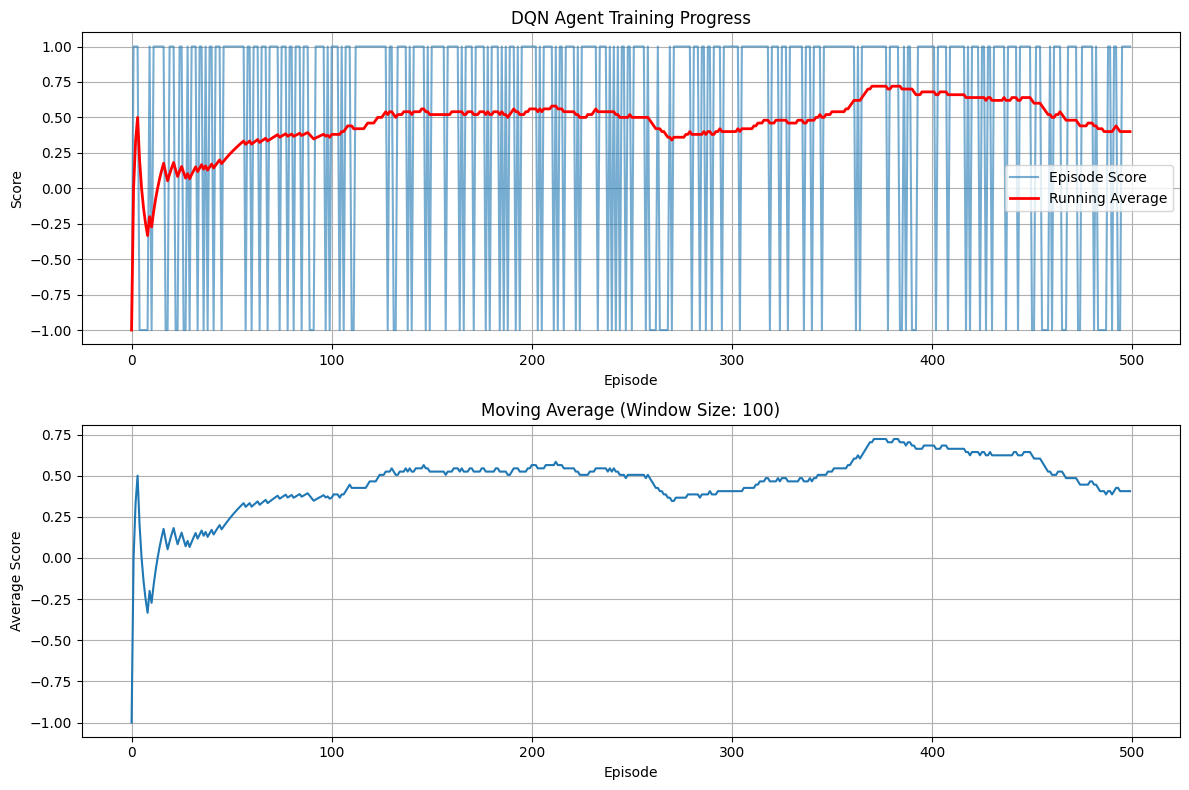

In [10]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(scores, alpha=0.6, label='Episode Score')
plt.plot(avg_scores, 'r', linewidth=2, label='Running Average')
plt.title('DQN Agent Training Progress')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
window_size = min(100, len(scores))
plt.plot([np.mean(scores[max(0, i-window_size):i+1]) for i in range(len(scores))])
plt.title(f'Moving Average (Window Size: {window_size})')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.grid(True)

plt.tight_layout()
plt.show()